## __Importando bibliotecas necessárias__

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tfw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

## __Defina o caminho para as pastas__

In [54]:
# Defina o caminho para a pasta
path = "C:\\Users\\PC\\Documents\\documents\\ifam\\TETI\\Listas_Atividades\\treinamento_efficieentNet\\produtos_regionais\\"
# Configurações do TensorBoard
log_dir = "C:\\Users\\PC\\Documents\\documents\\ifam\\TETI\\Listas_Atividades\\treinamento_efficieentNet\\logs"
# Pasta para salvar os modelos
output_dir = "C:\\Users\\PC\\Documents\\documents\\ifam\\TETI\\Listas_Atividades\\treinamento_efficieentNet\\models\\"
from tensorflow.keras.callbacks import TensorBoard

Callback TensorBoard configurado!


## __Criar o callback do TensorBoard__

In [ ]:
tensorboard_callback = TensorBoard(
    log_dir=log_dir,          # Diretório onde os logs serão armazenados
    histogram_freq=1,         # Frequência (em épocas) para calcular histogramas de pesos e ativações
    write_graph=True,         # Salva a arquitetura do modelo no log
    write_images=True,        # Salva as imagens das ativações dos filtros (útil para CNNs)
    update_freq='batch',      # Frequência de atualização dos logs: 'batch' ou 'epoch'
    profile_batch=0,          # Define lotes a serem analisados para profiling (0 = desativado)
    embeddings_freq=0         # Frequência de salvamento de embeddings (0 = desativado)
)

## __Configurações de Data Augmentation__

In [33]:
datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=10,      
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,        
    zoom_range=0.1,         
    horizontal_flip=True,    
    fill_mode='nearest'     
)

## __Gerando os dados de treino__

In [34]:
train_generator = datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),  # Redimensiona as imagens para 224x224 pixels
    class_mode='categorical',
    shuffle=False
)

Found 272 images belonging to 4 classes.


## __Gerando os dados de validação__

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=path + 'val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

## __Gerando os dados de teste__

In [35]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização, sem augmentação

test_generator = test_datagen.flow_from_directory(
    directory=path + 'test',  # Substitua pelo caminho do diretório de teste
    target_size=(224, 224),          # Redimensiona as imagens para 224x224 pixels
    batch_size=32,                   # Tamanho do lote
    class_mode='categorical',        # Codificação one-hot (ou None se apenas previsões forem necessárias)
    shuffle=False                    # Não embaralha, útil para manter a ordem original
)

Found 124 images belonging to 4 classes.


## __Definindo hiperparâmetros__

In [52]:
epochs = 50
batch_size = 32
learning_rate = 0.001
optimizer = Adam

## __Treinando modelo__

In [53]:
results = []
cont=1
try:
    # Configurando os geradores de dados
    train_generator.batch_size = batch_size
    validation_generator.batch_size = batch_size
    
    # Criando o modelo com EfficientNetV2B0
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compilando o modelo
    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Treinando o modelo
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[tensorboard_callback]
    )
    # Avaliando o modelo
    final_loss, final_accuracy = model.evaluate(validation_generator)
    best_model = model
    results.append({
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'optimizer': optimizer.__name__,
        'final_loss': final_loss,
        'final_accuuracy': final_accuracy,
        'loss': history.history['loss'][-1],  # A última perda de treino
        'accuracy': history.history['accuracy'][-1],  # A última acurácia de treino
        'val_loss': history.history['val_loss'][-1],  # A última perda de validação
        'val_accuracy': history.history['val_accuracy'][-1],  # A última acurácia de validação
        'history': history  # Armazenando o histórico completo
    })
    cont+=1
except Exception as e:
    print(f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer} {e}")

Epoch 1/50
9/9 [==============================] - 60s 6s/step - loss: 1.5551 - accuracy: 0.1471 - val_loss: 1.3917 - val_accuracy: 0.2500
Epoch 2/50
9/9 [==============================] - 42s 4s/step - loss: 1.2585 - accuracy: 0.4301 - val_loss: 1.4614 - val_accuracy: 0.2500
Epoch 3/50
9/9 [==============================] - 45s 5s/step - loss: 1.1650 - accuracy: 0.4706 - val_loss: 1.4323 - val_accuracy: 0.2500
Epoch 4/50
9/9 [==============================] - 48s 5s/step - loss: 1.2816 - accuracy: 0.5074 - val_loss: 1.4233 - val_accuracy: 0.2500
Epoch 5/50
9/9 [==============================] - 40s 4s/step - loss: 0.9104 - accuracy: 0.6728 - val_loss: 1.4117 - val_accuracy: 0.2500
Epoch 6/50
9/9 [==============================] - 51s 6s/step - loss: 0.6583 - accuracy: 0.7757 - val_loss: 1.4359 - val_accuracy: 0.2500
Epoch 7/50
9/9 [==============================] - 50s 5s/step - loss: 0.4043 - accuracy: 0.9412 - val_loss: 1.6194 - val_accuracy: 0.2344
Epoch 8/50
9/9 [==================

## __Convertendo resultados em DataFrame__

In [56]:
results_df = pd.DataFrame(results)
results_df.to_csv('results_com_dataAumentationReduzida.csv', index=False)
print(results_df)

## __Salvar o modelo__

In [58]:
model_name = f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer.__name__}_com_dataAugmentationReduzida.h5"
best_model.save(os.path.join(output_dir, model_name), save_format='h5')

## __Encontrar o melhor modelo com base na acurácia de validação__

In [ ]:
best_accuracy = 0
best_history = None

# Iterar sobre os resultados para encontrar o modelo com a maior val_accuracy
for result in results:
    val_accuracy = result.get('val_accuracy', 0)  # Obtém a acurácia de validação
    
    # Verifica se a acurácia de validação é maior que a atual
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_history = result  # Armazena o histórico do melhor modelo

## __Gerar gráfico do melhor modelo__

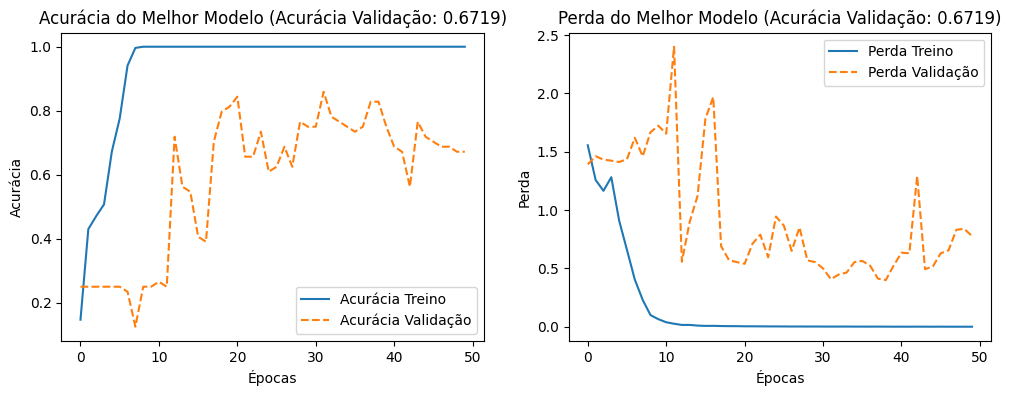

In [59]:
if best_history:
    plt.figure(figsize=(12, 4))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(best_history['history'].history['accuracy'], label='Acurácia Treino')
    plt.plot(best_history['history'].history['val_accuracy'], label='Acurácia Validação', linestyle='--')
    plt.title(f"Acurácia do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(best_history['history'].history['loss'], label='Perda Treino')
    plt.plot(best_history['history'].history['val_loss'], label='Perda Validação', linestyle='--')
    plt.title(f"Perda do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Exibindo os gráficos
    plt.show()
else:
    print("Nenhum modelo foi encontrado.")

## __Gerando a matriz de confusão para o melhor modelo__

2/2 [==============================] - 5s 2s/step


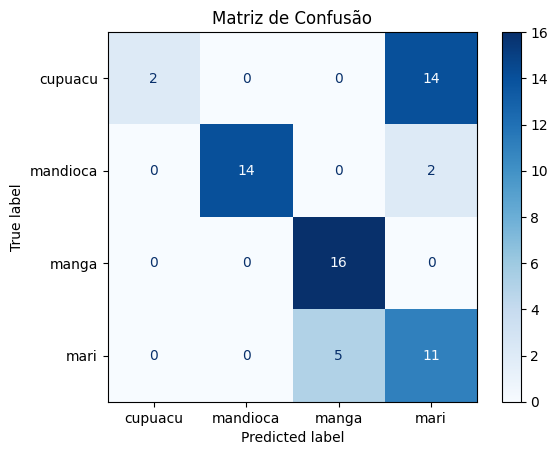

In [60]:
y_true = validation_generator.classes
y_pred = best_model.predict(validation_generator)  # Não precisa de ['model'], apenas use o objeto diretamente
y_pred_classes = np.argmax(y_pred, axis=1)

## __Criando a matriz de confusão__

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## __Avaliação do modelo com o conjunto de teste__

In [44]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Loss no conjunto de teste: {test_loss}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

4/4 [==============================] - 8s 2s/step - loss: 0.4058 - accuracy: 0.8145
Loss no conjunto de teste: 0.40580832958221436
Acurácia no conjunto de teste: 0.8145161271095276


## __Função de Predição__

In [63]:
def predict_image_class(image_path, model, class_indices):
    # Carregar a imagem
    img = load_img(image_path, target_size=(224, 224))  # Redimensiona para o tamanho usado no modelo
    img_array = img_to_array(img)  # Converte para array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = img_array / 255.0  # Normaliza os valores para o intervalo [0, 1]

    # Previsão
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]  # Índice da classe com maior probabilidade

    # Mapeando índice para a classe
    class_labels = {v: k for k, v in class_indices.items()}  # Inverte o mapeamento
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class

## __Exemplo de Previsão__

In [65]:
image_path = "C:/Users/PC/Documents/documents/ifam/TETI/Listas_Atividades/treinamento_efficieentNet/to_predict/manga.jpg"
predicted_class = predict_image_class(image_path, best_model, train_generator.class_indices)
print(f"A imagem pertence à classe: {predicted_class}")

AttributeError: 'NoneType' object has no attribute 'predict'

## __Finalizando o TensorBoard__

In [28]:
%load_ext tensorboard
%tensorboard --logdir C:/Users/PC/Documents/documents/ifam/TETI/Listas_Atividades/treinamento_efficieentNet/logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10688), started 20:12:59 ago. (Use '!kill 10688' to kill it.)

In [29]:
%reload_ext tensorboard